In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

In [3]:
# Load datasets
train_df = pd.read_csv("train.csv", parse_dates=["DateTime"])
test_df = pd.read_csv("test.csv", parse_dates=["DateTime"])

In [5]:
# Feature engineering
def add_time_features(df):
    df["hour"] = df["DateTime"].dt.hour
    df["day"] = df["DateTime"].dt.day
    df["month"] = df["DateTime"].dt.month
    df["weekday"] = df["DateTime"].dt.weekday
    df["is_weekend"] = df["weekday"].isin([5, 6]).astype(int)
    return df

In [7]:
train_df = add_time_features(train_df)
test_df = add_time_features(test_df)

In [11]:
train_df, test_df

(                 DateTime  Junction  Vehicles           ID  hour  day  month  \
 0     2015-11-01 00:00:00         1        15  20151101001     0    1     11   
 1     2015-11-01 01:00:00         1        13  20151101011     1    1     11   
 2     2015-11-01 02:00:00         1        10  20151101021     2    1     11   
 3     2015-11-01 03:00:00         1         7  20151101031     3    1     11   
 4     2015-11-01 04:00:00         1         9  20151101041     4    1     11   
 ...                   ...       ...       ...          ...   ...  ...    ...   
 48115 2017-06-30 19:00:00         4        11  20170630194    19   30      6   
 48116 2017-06-30 20:00:00         4        30  20170630204    20   30      6   
 48117 2017-06-30 21:00:00         4        16  20170630214    21   30      6   
 48118 2017-06-30 22:00:00         4        22  20170630224    22   30      6   
 48119 2017-06-30 23:00:00         4        12  20170630234    23   30      6   
 
        weekday  is_weeken

In [13]:
# Features for training
features = ["Junction", "hour", "day", "month", "weekday", "is_weekend"]
X_train = train_df[features]
y_train = train_df["Vehicles"]
X_test = test_df[features]

In [15]:
# Train the final model
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [17]:
from sklearn.model_selection import train_test_split

# Create validation split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [19]:
# Train and predict
model.fit(X_tr, y_tr)
y_pred = model.predict(X_val)

In [23]:
y_pred

array([ 8.142057, 25.74214 , 10.108797, ..., 11.510229,  8.142318,
       16.108963], dtype=float32)

In [25]:
# Evaluation
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("Final MAE:", mae)
print("Final RMSE:", rmse)

Final MAE: 6.407250881195068
Final RMSE: 9.658995599123479


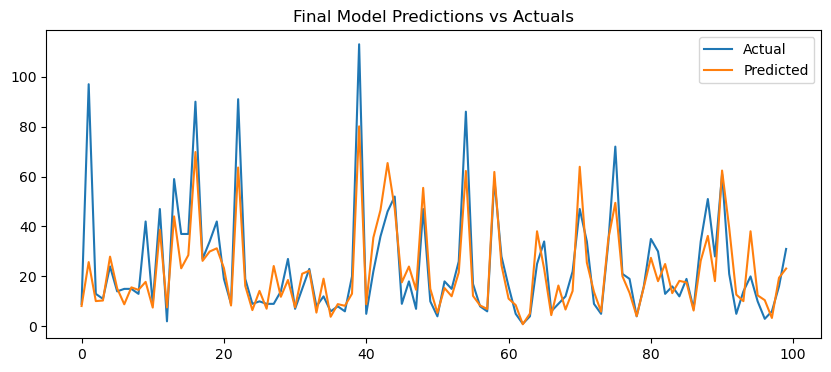

In [27]:
# Plotting predictions
plt.figure(figsize=(10, 4))
plt.plot(y_val.values[:100], label="Actual")
plt.plot(y_pred[:100], label="Predicted")
plt.legend()
plt.title("Final Model Predictions vs Actuals")
plt.show()

In [29]:
# Predict on test data
test_df["Vehicles"] = model.predict(X_test)

In [31]:
# Save submission file
submission = test_df[["ID", "Vehicles"]]
submission.to_csv("final_submission.csv", index=False)
submission.head()

,ID,Vehicles
0,20170701001,40.836407
1,20170701011,33.412148
2,20170701021,25.362255
3,20170701031,20.465952
4,20170701041,15.444436
